In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Convolutional Neural Network for FashionMNIST


We use a model with two gidden `torch.nn.Linear` layers.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


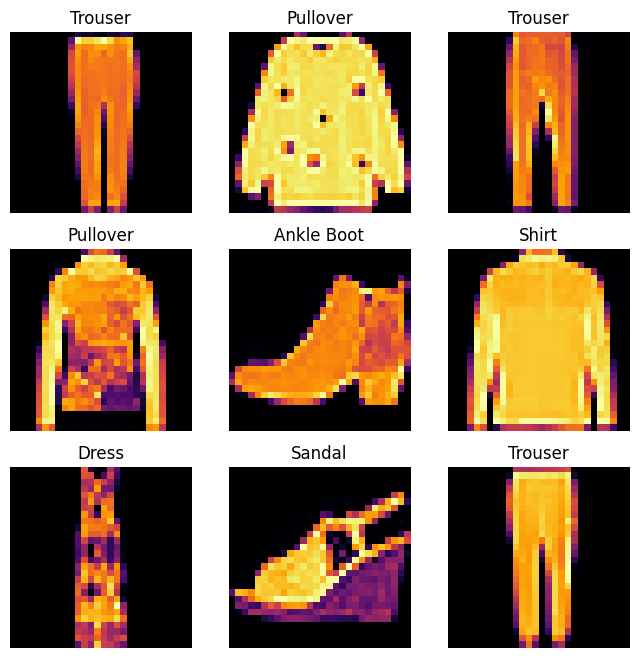

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="inferno")
plt.show()


# Convolutional Neural Network
## Convolution layers
A convolutional layer takes 4 hyperparameters:
- Number of filters $K$
- The filter size, or kernel size $F$
- The stride $S$
- The amount of padding $P$

In [39]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 12, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fully_connected = nn.Linear(588,10)


    def forward(self, x):
        x = self.convolutions(x)
        x = self.flatten(x)
        logits = self.fully_connected(x)
        return logits

model = ConvolutionalNeuralNetwork().to(device)
print(model)

Using mps device
ConvolutionalNeuralNetwork(
  (convolutions): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fully_connected): Linear(in_features=588, out_features=10, bias=True)
)


In [40]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    output = model(X.to(device))
    print(f"Shape of output: {output.shape}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of output: torch.Size([64, 10])


In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [42]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [43]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304215  [   64/60000]
loss: 0.854534  [ 6464/60000]
loss: 0.527413  [12864/60000]
loss: 0.693603  [19264/60000]
loss: 0.613217  [25664/60000]
loss: 0.629409  [32064/60000]
loss: 0.574113  [38464/60000]
loss: 0.652862  [44864/60000]
loss: 0.609995  [51264/60000]
loss: 0.490234  [57664/60000]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.481169 

Epoch 2
-------------------------------
loss: 0.370056  [   64/60000]
loss: 0.426633  [ 6464/60000]
loss: 0.294175  [12864/60000]
loss: 0.542383  [19264/60000]
loss: 0.464478  [25664/60000]
loss: 0.473069  [32064/60000]
loss: 0.385678  [38464/60000]
loss: 0.673553  [44864/60000]
loss: 0.616707  [51264/60000]
loss: 0.415718  [57664/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.419411 

Epoch 3
-------------------------------
loss: 0.316661  [   64/60000]
loss: 0.362355  [ 6464/60000]
loss: 0.251778  [12864/60000]
loss: 0.496543  [19264/60000]
loss: 0.406752  [25664/60000]
loss: 0.443214  [32064/600

In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")


Saved PyTorch Model State to model.pth


In [14]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


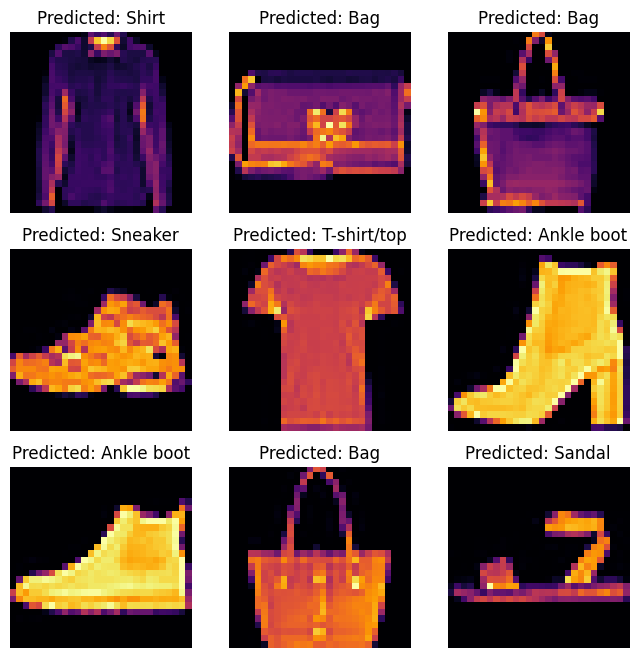

In [23]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]

# Make a prediction with our trained model
    img = img.to(device)
    pred = model(img)

    figure.add_subplot(rows, cols, i)
    plt.title(f'Predicted: {classes[pred[0].argmax(0)]}')
    plt.axis("off")
    plt.imshow(img.cpu().squeeze(), cmap="inferno")
plt.show()